min resistance: 0.021 
max resistance: 0.034


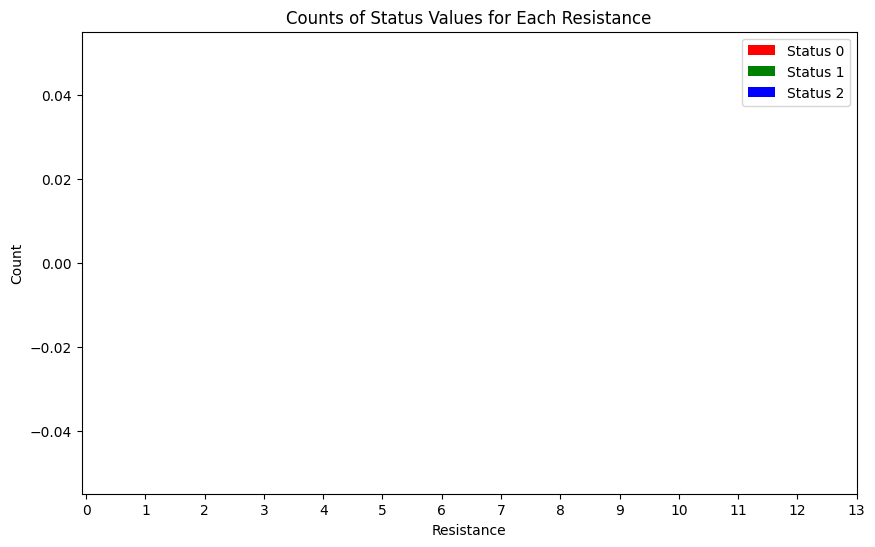

In [5]:
#Comparison maps
import os
import glob
import json
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from wlt.duts.wafers import WAFER_MAPS
from wlt.wafermap import WaferMap
from datetime import datetime

#graph config
status_vs_resistance = False
asym_vs_resistance = False
failure_map = False

#init
root_path = os.path.expanduser('~/WLT/WLT_v1.2.1/croc_wlt/data')
path_2 = [entry for entry in os.listdir(root_path) if not entry.startswith('.')]
wafer_count = 0
wafer_data = {}
json_pattern = r'chip_(.*).json'
analog_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}).*\((\S\S\S\S\-\w\w)\).*Contact resistance \(analog\): (\d+\.\d+) ohm'
chipid_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Testing chip \S\S\S\S\S\S\S\S\S\S\S\S(\S\S)'
contact_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Found contact height: (.*)'
asympattern = r'.* \| .* \| .* \| Asymmetry \((.*) um\)'
edge1pattern = r'.* \| .* \| .* \| Edge sensor 1: (.*)'
edge2pattern = r'.* \| .* \| .* \| Edge sensor 2: (.*)'

#test  init
contactheight = []


#formatting chips function
letter_to_number = {
    'A': '10', 'B': '11', 'C': '12', 'D': '13', 'E': '14', 'F': '15'}
def multiple_substitutions(s):
    chip_coords = f'({s[0]},{s[1]})'
    pattern = re.compile('|'.join(map(re.escape, letter_to_number.keys())))
    return pattern.sub(lambda match: letter_to_number[match.group(0)], chip_coords)

#initializing waferid and chipid in dictionary
def initialize_entry(wafer_data, wafer_id, chip_label):
    # Initialize wafer_id if not already in wafer_data
    if wafer_id not in wafer_data:
        wafer_data[wafer_id] = {}
    # Initialize chip_id if not already in wafer_data[wafer_id]
    if chip_label not in wafer_data[wafer_id]:
        wafer_data[wafer_id][chip_label] = {
            'contact_resistance': 'N/A',
            'contact_height': 'N/A',
            'asymmetry': 'N/A',
            'chip_status': 'N/A',
            'failure_reason': 'N/A'
        }
    return wafer_data

#main search
for item in path_2:
    wafer_count += 1
    wafer_id = item[-4:]
    wafer_folder = os.path.join(root_path, item) #ex ~/filepath/wafer_NC0W14-0XXX
    directories = os.listdir(wafer_folder) #ex 2024XXXX_XXXXXX
    most_recent_subdir = None
    most_recent_time = datetime.min
    #find most recent subdir format ex 2024XXXX_XXXXXX
    for folder in directories:
        if os.path.isdir(os.path.join(wafer_folder, folder)):
            full_path = os.path.join(wafer_folder, folder)
            modified_time = datetime.fromtimestamp(os.path.getmtime(full_path))
            if modified_time > most_recent_time:
                most_recent_time = modified_time
                most_recent_subdir = full_path
                date_folder = folder
                
    #open log file to search for contact resistances by chip FORMAT CHIPS FIRST
    log_path = os.path.join(most_recent_subdir, f'{item}_{date_folder}.log')
    with open(log_path, 'r') as file:
        log_content = file.readlines()
    for i in range(len(log_content)):
        contact_height = 'N/A'
        chip_label = 'N/A'
        analog_match = re.search(analog_pattern, log_content[i])
        contactmatch = re.search(contact_pattern, log_content[i])
        
        #find contact resistances
        if analog_match:
            chip = analog_match.group(2)[-2:]
            chip_label = multiple_substitutions(chip)
            wafer_id = analog_match.group(2)[:4]
            resistance = float(analog_match.group(3))  # Convert resistance to float
            if chip_label is not None and wafer_id is not None and resistance is not None:
                wafer_data = initialize_entry(wafer_data, wafer_id, chip_label)
                # Append chip_status to chip_id in wafer_data (note: this will only use the most recent resistance. could edit to take average)
                wafer_data[wafer_id][chip_label]['contact_resistance'] = resistance
        
        #find contact heights
        if contactmatch:
            j = i
            chip_label = 'N/A'
            while j > 0:
                chipmatch = re.search(chipid_pattern, log_content[j])
                if chipmatch: 
                    contact_height = contactmatch.group(3)[:5]
                    height_chip = chipmatch.group(3)
                    chip_label = multiple_substitutions(height_chip)
                    wafer_data = initialize_entry(wafer_data, wafer_id, chip_label)
                    # Append contact_height to chip_id in wafer_data
                    wafer_data[wafer_id][chip_label]['contact_height'] = contact_height
                    j = 0
                else:
                    j -=1
            if j == 0 and chip_label == 'N/A':
                print('Could not find chip associated with the contact height')
            
            #find asymmetry    
            asymmatch = re.search(asympattern, log_content[i-1])
            edge1match = re.search(edge1pattern, log_content[i-8])
            edge2match = re.search(edge2pattern, log_content[i-7])
            if asymmatch and edge1match and edge2match:
                edge1 = str(edge1match.group(1))
                edge2 = str(edge2match.group(1))
                wafer_data = initialize_entry(wafer_data, wafer_id, chip_label)
                asymmetry = str(asymmatch.group(1))
                if edge1 == "False" and edge2 == "True":
                    wafer_data[wafer_id][chip_label]['asymmetry'] = asymmetry
                elif edge1 == "True" and edge2 == "False":
                    asymmetry = str('-' + str(asymmetry))
                    wafer_data[wafer_id][chip_label]['asymmetry'] = asymmetry
                elif (edge1 == "True" and edge2 == "True") or (edge1 == "False" and edge2 == "False"):
                    wafer_data[wafer_id][chip_label]['asymmetry'] = asymmetry
                else:
                    print('edge sensor error')
            else: #idk why but this is necessary because sometimes the line location of the edge sensor messages changes
                asymmatch = re.search(asympattern, log_content[i-1])
                edge1match = re.search(edge1pattern, log_content[i-3]) #changed this
                edge2match = re.search(edge2pattern, log_content[i-2]) #changed this
                if asymmatch and edge1match and edge2match:
                    edge1 = str(edge1match.group(1))
                    edge2 = str(edge2match.group(1))
                    wafer_data = initialize_entry(wafer_data, wafer_id, chip_label)
                    asymmetry = str(asymmatch.group(1))
                    if edge1 == "False" and edge2 == "True":
                        wafer_data[wafer_id][chip_label]['asymmetry'] = asymmetry
                    elif edge1 == "True" and edge2 == "False":
                        asymmetry = str('-' + str(asymmetry))
                        wafer_data[wafer_id][chip_label]['asymmetry'] = asymmetry
                    elif (edge1 == "True" and edge2 == "True") or (edge1 == "False" and edge2 == "False"):
                        wafer_data[wafer_id][chip_label]['asymmetry'] = asymmetry
                    else:
                        print('edge sensor error')
                else:
                    print(f'no asymmetry match in line {i} in wafer {item}')
    
    #plots/db/json files (getting chip status and failure reason)
    plots_db_path = os.path.join(most_recent_subdir, 'plots', 'db')
    for root, dirs, files in os.walk(plots_db_path):
        for filename in files:
            if re.search(json_pattern, filename):
                filepath = os.path.join(plots_db_path, filename)
                # Open and process JSON file
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    chip_col = data.get("CHIP_COL")
                    chip_row = data.get("CHIP_ROW")
                    grade = data.get("GRADE")
                    failure_reason = data.get("FAILURE_REASON")
                    # Convert grade to number
                    if grade == 'red':
                        chip_status = 2
                    elif grade == 'yellow':
                        chip_status = 1
                    elif grade == 'green':
                        chip_status = 0
                    else:
                        print('unrecognized grade')
                        chip_status = -1
                    if chip_col is not None and chip_row is not None and grade is not None:
                        chip_label = f'({chip_col},{chip_row})'
                        wafer_data = initialize_entry(wafer_data, wafer_id, chip_label)
                        # Append chip_status to chip_id in wafer_data
                        wafer_data[wafer_id][chip_label]['chip_status'] = chip_status
                        wafer_data[wafer_id][chip_label]['failure_reason'] = failure_reason

#print(wafer_data)
#sort into new dictionaries for easier plotting
chip_statuses = {}
resistances_vs_s = []
statuses_vs_r = []
a_vs_r = []
r_vs_a = []
for wafer_id, data in wafer_data.items():
    for chip_id, chip_data in data.items():
        resistance = chip_data['contact_resistance']
        height = chip_data['contact_height']
        asymmetry = chip_data['asymmetry']
        status = chip_data['chip_status']
        failure_reason = chip_data['failure_reason']
        if chip_id in chip_statuses:
            if isinstance(chip_statuses[chip_id], list):
                chip_statuses[chip_id].append(status)
            else:
                chip_statuses[chip_id] = [chip_statuses[chip_id], status]  # Convert to list if it's a string
        else:
            # Initialize as a list and append the grade
            chip_statuses[chip_id] = [status]
        
        #get resistance and status lists
        if resistance != 'N/A' and status != 'N/A':
            resistances_vs_s.append(resistance)
            statuses_vs_r.append(status)
        if asymmetry != 'N/A' and resistance != 'N/A':
            a_vs_r.append(asymmetry)
            r_vs_a.append(resistance)
            
'''
#plot resistance vs status
plt.figure(figsize=(8, 6)) 
plt.scatter(resistances_vs_s, statuses_vs_r, marker='o', linestyle='-', color='b', label='Data')  # Plot x_data vs y_data

plt.xlabel('resistances')
plt.ylabel('statuses')
plt.title('status vs resistance')
plt.legend()   
plt.grid(True)  # Optional: add grid lines
plt.show() 

status_0 = []
status_1 = []
status_2 = []
for i in range(len(resistances_vs_s)):
    if statuses_vs_r[i] == 0:
        status_0.append(resistances_vs_s[i])
    if statuses_vs_r[i] == 1:
        status_1.append(resistances_vs_s[i])
    if statuses_vs_r[i] == 2:
        status_2.append(resistances_vs_s[i])

print(status_0)
print(status_1)
print(status_2)
    
plt.figure(figsize=(10, 6))
bar_width = 0.2
opacity = 0.7

statuses_labels = ['Status 0', 'Status 1', 'Status 2']
X_axis = np.arange(len(statuses_labels)) 

plt.xlabel('Resistances')
plt.ylabel('Count')
plt.title('Number of Points at Each Status for Each Resistance Bin')
plt.xticks(bins)
plt.legend()
plt.tight_layout()
plt.show()
'''

status_resistance_bar = True
if status_resistance_bar == True:
    # Count occurrences of each (status, resistance) pair
    status_resistance_counts = {}
    for s, r in zip(statuses_vs_r, resistances_vs_s):
        if (s, r) in status_resistance_counts:
            status_resistance_counts[(s, r)] += 1
        else:
            status_resistance_counts[(s, r)] = 1

    # Separate counts by resistance value
    num_statuses = 3  # Number of different status values
    unique_resistances = sorted(set(resistances_vs_s))
    num_resistances = len(unique_resistances)
    
    # Initialize counts for each resistance
    counts_by_resistance = [[] for _ in range(num_resistances)]

    # Fill counts_by_resistance with counts from status_resistance_counts
    for r in range(num_resistances):
        for s in range(num_statuses):
            counts_by_resistance[r].append(status_resistance_counts.get((s, r), 0))

    # Convert lists to numpy arrays for plotting
    counts_by_resistance = np.array(counts_by_resistance)

    # Find actual range of resistance values
    min_resistance = min(resistances_vs_s)
    max_resistance = max(resistances_vs_s)
    print(f'min resistance: {min_resistance} \nmax resistance: {max_resistance}')

    # Plotting
    width = 0.2  # Width of each bar
    ind = np.arange(num_resistances)  # x locations for the groups

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['r', 'g', 'b']  # Colors for different status values

    # Plot bars for each status value
    for i, color in zip(range(num_statuses), colors):
        ax.bar(ind + i*width, counts_by_resistance[:, i], width, label=f'Status {i}', color=color)
    
    ax.set_xlim(min_resistance, max_resistance)
    ax.set_xlabel('Resistance')
    ax.set_ylabel('Count')
    ax.set_title('Counts of Status Values for Each Resistance')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(np.arange(num_resistances))
    ax.legend()
    plt.show()




if status_vs_resistance == True:
    plt.figure(figsize=(8,10))
    plt.hist2d(statuses_vs_r, resistances_vs_s, bins=14, cmap='Blues')
    plt.colorbar(label='count in bin')
    plt.xlabel('statuses')
    plt.ylabel('resistances')
    plt.title('status vs resistance')
    plt.show()

if asym_vs_resistance == True:
    plt.figure(figsize=(10,6))
    plt.scatter(a_vs_r, r_vs_a, alpha=0.5, s=200)
    plt.xlabel('Asymmetry (um)')
    plt.ylabel('Analog Contact Resistance (ohm)')
    plt.title('Resistance vs Asymmetry')
    plt.show()

if failure_map == True:
    #Bin statuses
    always_green = []
    always_yellow = []
    always_red = []
    lime = []
    orange = []
    undefined = []

    for key, value in chip_statuses.items():
        average_value = sum(value) / len(value)
        if all(v == 0 for v in value):
            always_green.append(key)
        elif all(v == 1 for v in value):
            always_yellow.append(key)
        elif all(v == 2 for v in value):
            always_red.append(key)
        elif 0 <= average_value < 1:
            lime.append(key)
        elif 1 <= average_value < 2:
            orange.append(key)
        else:
            undefined.append(key)

    #set statuses
    chip_statuses = {
            ( 0, ''): always_green,    
            ( 0.5, ''): lime,                
            ( 1, ''): always_yellow, 
            ( 1.5, ''): orange,              
            ( 2, ''): always_red,
            ( 3, ''): undefined,
    }

    WaferMap.STATUS_COLORS = {0: '#009933', 0.5: '#99ff33', 1: '#ffff00', 1.5: '#ff9900', 2: '#ff0000', 3: '#666699'}
    WaferMap.STATUS_NAMES =  {0: 'g', 0.5: 'l', 1: 'y', 1.5: 'o', 2: 'r', 3: 'u'}

    #Create status map
    loop = 0
    ch_type ='CROCv2'
    wafer_map = WaferMap(chip_type=ch_type, title=f'Wafer comparison')
    for (chip_status, chip_value), x in chip_statuses.items():
        for chips in x:
            #subtext = f"{heights}um"
            subtext = ''
            wafer_map.set_chip(eval(chips), chip_status, subtext)
            loop = loop + 1

    #printing stats
    print(f'Total wafers: {wafer_count}')
    if len(always_green) > 0:
        print(f'Always green: {always_green}')
    if len(always_yellow) > 0:
        print(f'Always yellow: {always_yellow}')
    if len(always_red) > 0: 
        print(f'Always red: {always_red}')
    if len(undefined) > 0:
        print(f'Undefined: {undefined}')



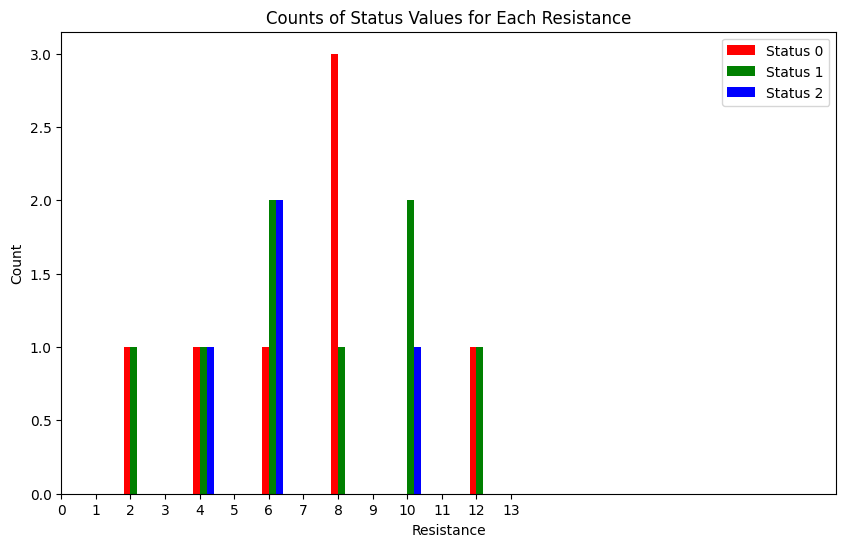

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
status = [0, 1, 1, 2, 0, 1, 0, 2, 0, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 2]
resistance = [2, 4, 6, 6, 8, 10, 4, 6, 8, 10, 12, 8, 6, 4, 2, 12, 10, 8, 6, 22]

# Count occurrences of each (status, resistance) pair
status_resistance_counts = {}
for s, r in zip(status, resistance):
    if (s, r) in status_resistance_counts:
        status_resistance_counts[(s, r)] += 1
    else:
        status_resistance_counts[(s, r)] = 1

# Separate counts by resistance value
num_statuses = 3  # Number of different status values
num_resistances = 14  # Number of different resistance values

# Initialize counts for each resistance
counts_by_resistance = [[] for _ in range(num_resistances)]

# Fill counts_by_resistance with counts from status_resistance_counts
for r in range(num_resistances):
    for s in range(num_statuses):
        counts_by_resistance[r].append(status_resistance_counts.get((s, r), 0))

# Convert lists to numpy arrays for plotting
counts_by_resistance = np.array(counts_by_resistance)

# Find actual range of resistance values
min_resistance = min(resistance)
max_resistance = max(resistance)

# Plotting
width = 0.2  # Width of each bar
ind = np.arange(num_resistances)  # x locations for the groups

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['r', 'g', 'b']  # Colors for different status values

# Plot bars for each status value
for i, color in zip(range(num_statuses), colors):
    ax.bar(ind + i*width, counts_by_resistance[:, i], width, label=f'Status {i}', color=color)

# Set x-axis limits based on the actual range of resistance values
ax.set_xlim(min_resistance - 0.5, max_resistance + 0.5)

ax.set_xlabel('Resistance')
ax.set_ylabel('Count')
ax.set_title('Counts of Status Values for Each Resistance')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(np.arange(num_resistances))
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
x = np.random.randn(1000)
y = np.random.randn(1000)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter Plot with Transparency')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hexbin(x, y, gridsize=50, cmap='Blues')
plt.colorbar(label='count in bin')
plt.title('Hexbin Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist2d(x, y, bins=30, cmap='Blues')
plt.colorbar(label='count in bin')
plt.title('2D Histogram')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()